<a href="https://colab.research.google.com/github/rsuth/lineupcounter/blob/master/lineupcounter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pylab inline
import numpy as np
import cv2
from tqdm import trange
import pandas as pd
import json
import scipy.spatial
from scipy.ndimage import gaussian_filter
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torch.autograd import Variable
np.set_printoptions(suppress=True)

Populating the interactive namespace from numpy and matplotlib


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(device, torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print(device)

cuda Tesla T4


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

frames_dir = '/content/drive/My Drive/Colab Notebooks/DensityMaps/frames'

Mounted at /content/drive


In [4]:
# get input files and points
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DensityMaps/surfercount-points_csv.csv')
file_label_pairs = []
for filename in set(df['filename']):
    points = df[df['filename'] == filename]['point']
    points_objs = []
    for p in points:
        points_objs.append(json.loads(p))
    file_label_pairs.append((filename, points_objs))

In [6]:
# read, resize images and relocate points
SIZE_MULT = 2

resized_images = []
new_W = 72
new_W = new_W * SIZE_MULT
for filename, points in file_label_pairs:
    img_pre = cv2.imread(f'{frames_dir}/resize/{filename}')
    img_pre = cv2.cvtColor(img_pre, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img_pre, dsize=(new_W,new_W), interpolation=cv2.INTER_CUBIC)
    Xratio = new_W/img_pre.shape[1]
    Yratio = new_W/img_pre.shape[0]
    ratios = [Xratio, Yratio]
    resized_points = []
    for point in points:
      if 'cx' in point.keys():
        resized_point = (int(point['cx'] * Xratio), int(point['cy'] * Yratio))
        resized_points.append(resized_point)
    resized_images.append((img/255, resized_points))

df = pd.DataFrame(resized_images)
df.columns = ['image', 'points']

In [11]:
# DEFINE MODEL

def conv_block(channels, size, stride=(1, 1), N=2):
    """
    Create a block with N convolutional layers with ReLU activation function.
    The first layer is IN x OUT, and all others - OUT x OUT.
    Args:
        channels: (IN, OUT) - no. of input and output channels
        size: kernel size (fixed for all convolution in a block)
        stride: stride (fixed for all convolution in a block)
        N: no. of convolutional layers
    Returns:
        A sequential container of N convolutional layers.
    """
    # a single convolution + batch normalization + ReLU block
    block = lambda in_channels: nn.Sequential(
        nn.Conv2d(in_channels=in_channels,
                  out_channels=channels[1],
                  kernel_size=size,
                  stride=stride,
                  bias=False,
                  padding=(size[0] // 2, size[1] // 2)),
        nn.BatchNorm2d(num_features=channels[1]),
        nn.ReLU()
    )
    # create and return a sequential container of convolutional layers
    # input size = channels[0] for first block and channels[1] for all others
    return nn.Sequential(*[block(channels[bool(i)]) for i in range(N)])


class RickNet(nn.Module):
    def __init__(self, N=1, input_filters=1, **kwargs):
        """
            https://github.com/NeuroSYS-pl/objects_counting_dmap/blob/master/model.py
            Fully Convolutional Regression Network A
            Ref. W. Xie et al. 'Microscopy Cell Counting with Fully Convolutional
            Regression Networks'
        Create FCRN-A model with:
            * fixed kernel size = (3, 3)
            * fixed max pooling kernel size = (2, 2) and upsampling factor = 2
            * no. of filters as defined in an original model:
              input size -> 32 -> 64 -> 128 -> 512 -> 128 -> 64 -> 1
        Args:
            N: no. of convolutional layers per block (see conv_block)
            input_filters: no. of input channels
        """
        super(RickNet, self).__init__()
        self.model = nn.Sequential(
            # downsampling
            conv_block(channels=(input_filters, 32), size=(3,3), N=N),
            nn.MaxPool2d(2),

            conv_block(channels=(32,64), size=(3,3), N=N),
            nn.MaxPool2d(2),

            conv_block(channels=(64,128), size=(3,3), N=N),
            nn.MaxPool2d(2),

            # conv "fully connected"
            conv_block(channels=(128,512), size=(3,3), N=N),

            nn.Upsample(scale_factor=2),
            conv_block(channels=(512,128), size=(3,3), N=N),

            nn.Upsample(scale_factor=2),
            conv_block(channels=(128,64), size=(3,3), N=N),

            nn.Upsample(scale_factor=2),
            conv_block(channels=(64,1), size=(3,3), N=N),

        )
            
    
    def forward(self, x):
      return self.model(x)

def get_output_shape(m, image_dim):
    return m(torch.rand(*(image_dim))).data.shape

out_shape = get_output_shape(RickNet(), (1, 1, new_W, new_W))
out_W = out_shape[-1]
print(f'output_shape: {out_shape}')
print(out_W)
print(RickNet(bn=True))

output_shape: torch.Size([1, 1, 144, 144])
144
RickNet(
  (model): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Sequential(
      (0): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


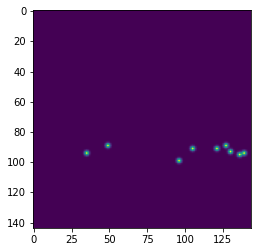

In [12]:
# create ground truth density maps
GAUSS_SIGMA=1
Xratio = out_W/new_W
Yratio = out_W/new_W
density_maps = []
for points in df['points']:
    dot_map = np.zeros((out_W,out_W))
    for p in points:
        new_p = (int(p[1] * Xratio), int(p[0] * Yratio))
        dot_map[new_p[0],new_p[1]] = 100
    density_map = gaussian_filter(dot_map, sigma=GAUSS_SIGMA, order=0)
    density_maps.append(density_map)
df['dmap'] = density_maps

imshow(df['dmap'][0])

In [13]:
# set up training
learning_rate = 1e-4
BS = 16
EPOCHS = 500

model = RickNet()
model.to(device)
train_X, test_X, train_Y, test_Y = train_test_split(df['image'], df['dmap'], test_size=0.33, random_state=1)

loss_function = nn.MSELoss()
optim = torch.optim.SGD(model.parameters(),
                                lr=learning_rate,
                                momentum=0.9,
                                weight_decay=1e-5)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optim,
                                                step_size=20,
                                                gamma=0.1)


100%|██████████| 500/500 [00:20<00:00, 24.22it/s]


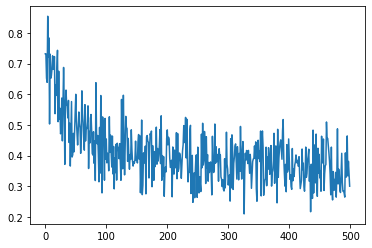

In [14]:
losses = []
for i in (trange(EPOCHS)):
    # prep the batch
    samp = np.random.randint(0, train_X.shape[0], size=(BS))
    X = torch.tensor(np.vstack(train_X.values[samp]).astype(np.float).reshape((-1, 1, new_W, new_W))).float().cuda()
    Y = torch.tensor(np.vstack(train_Y.values[samp]).astype(np.float).reshape((-1, 1, out_W, out_W))).float().cuda()
    
    # train
    model.train()
    optim.zero_grad()
    out = model(X)
    loss = loss_function(out, Y)
    loss.backward()
    optim.step()
    # stats
    losses.append(float(loss))

plt.plot(losses)

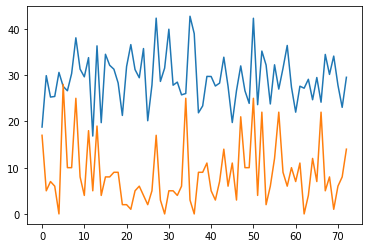

In [17]:
# Evaluation
dmap_preds = []
dmap_trues = []
input_imgs = []
count_preds = []
count_trues = []

for k in range(len(test_X.values)):
    x = torch.tensor(test_X.values[k].astype(np.float).reshape((1, 1, new_W, new_W))).float().cuda()
    with torch.no_grad():
        pred = model(x)
        pred = pred.cpu()
    dmap_preds.append(pred.reshape((out_W, out_W, 1)))
    count_preds.append(np.sum(np.array(pred))/100)
    dmap_trues.append(test_Y.values[k])
    count_trues.append(np.sum(np.array(test_Y.values[k]))/100)
    input_imgs.append(test_X.values[k])
  
plot(count_preds)
plot(count_trues)

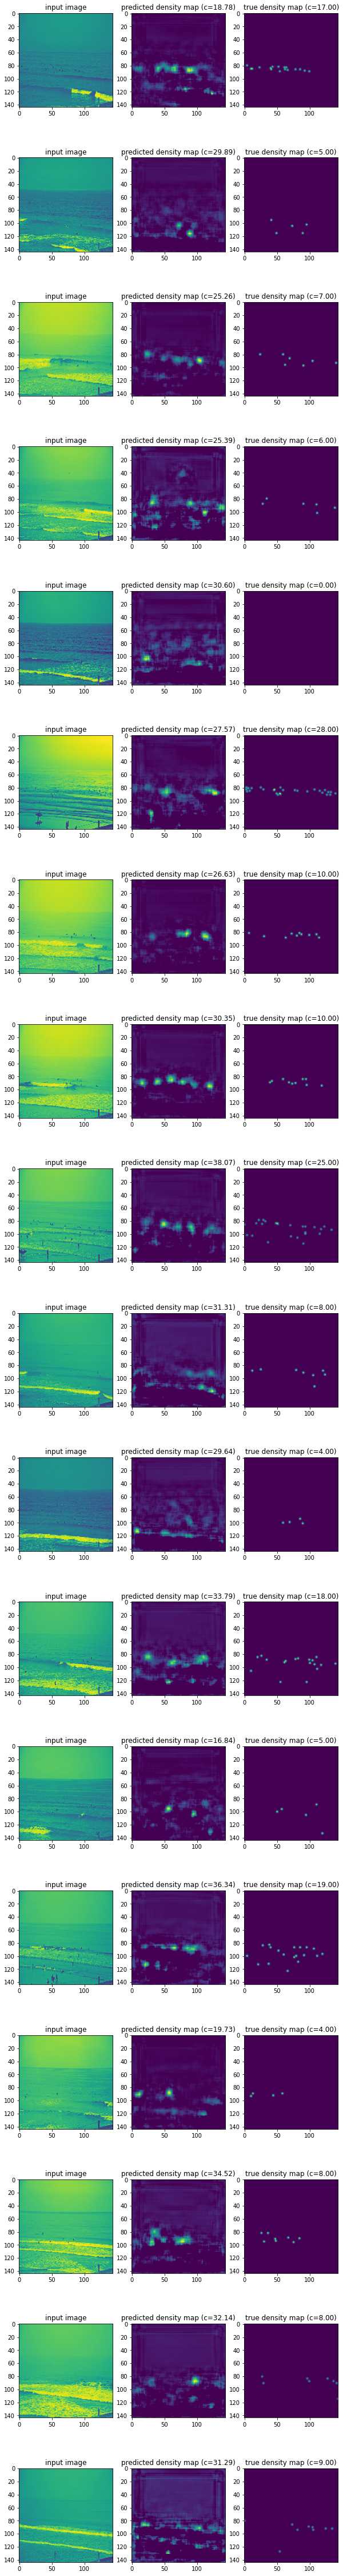

In [18]:
i = len(input_imgs)//4
fig = figure(figsize=(10,4.6*i))
axs = fig.subplots(i, 3)

for k in range(i):
    axs[k][0].set_title('input image')
    axs[k][1].set_title(f'predicted density map (c={count_preds[k]:.2f})')
    axs[k][2].set_title(f'true density map (c={count_trues[k]:.2f})')
    axs[k][0].imshow(input_imgs[k])
    axs[k][1].imshow(dmap_preds[k].reshape(out_W, out_W))
    axs[k][2].imshow(dmap_trues[k].reshape(out_W, out_W))